<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Light_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install insist-pista --quiet

In [ ]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
import pista as pt
from pista.utils import Xmatch, generate_psf
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter
from PIL import Image, ImageDraw
import cv2
import imageio
import glob
from scipy.stats import skewnorm
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.io import fits
import requests


In [ ]:
data_path = pt.data_dir

In [ ]:
def light_curve(x, y, cadence):
  x_new = np.arange(x[0], x[-1], cadence)
  y_new = np.interp(x_new, x, y)
  return x_new, y_new

In [ ]:
morse = {'A': [0,1,0,1,1,1],
         'B': [0,1,1,1,0,1,0,1,0,1],
         'C': [0,1,1,1,0,1,0,1,1,1,0,1],
         'D': [0,1,1,1,0,1,0,1],
         'E': [0,1],
         'F': [0,1,0,1,0,1,1,1,0,1],
         'G': [0,1,1,1,0,1,1,1,0,1],
         'H': [0,1,0,1,0,1,0,1],
         'I': [0,1,0,1],
         'J': [0,1,0,1,1,1,0,1,1,1,0,1,1,1],
         'K': [0,1,1,1,0,1,0,1,1,1],
         'L': [0,1,0,1,1,1,0,1,0,1],
         'M': [0,1,1,1,0,1,1,1],
         'N': [0,1,1,1,0,1],
         'O': [0,1,1,1,0,1,1,1,0,1,1,1],
         'P': [0,1,0,1,1,1,0,1,1,1,0,1],
         'Q': [0,1,1,1,0,1,1,1,0,1,0,1,1,1],
         'R': [0,1,0,1,1,1,0,1],
         'S': [0,1,0,1,0,1],
         'T': [0,1,1,1],
         'U': [0,1,0,1,0,1,1,1],
         'V': [0,1,0,1,0,1,0,1,1,1],
         'W': [0,1,0,1,1,1,0,1,1,1],
         'X': [0,1,1,1,0,1,0,1,0,1,1,1],
         'Y': [0,1,1,1,0,1,0,1,1,1,0,1,1,1],
         'Z': [0,1,1,1,0,1,1,1,0,1,0,1],
         ' ': [0,0,0],
         }

In [41]:
code = 'TELL MACY PETRICHOR'
morse_code = []
for c in code:
  morse_code+= morse[c]
  morse_code += [0,0,0]

y_in = np.array(morse_code)

In [42]:
x_in = np.arange(0, len(y_in), 1)
t,dmag = light_curve(x_in, y_in, 0.1)
len(dmag)

1980

In [ ]:
start = 0
end = 20*60

num_points = 1000

x_in = np.arange(start, end, 1)
y_in = skewnorm.pdf(x_in, 10, loc=400, scale=2*60)

t,dmag = light_curve(x_in, y_in, 0.1)
dmag = -dmag/dmag.max()

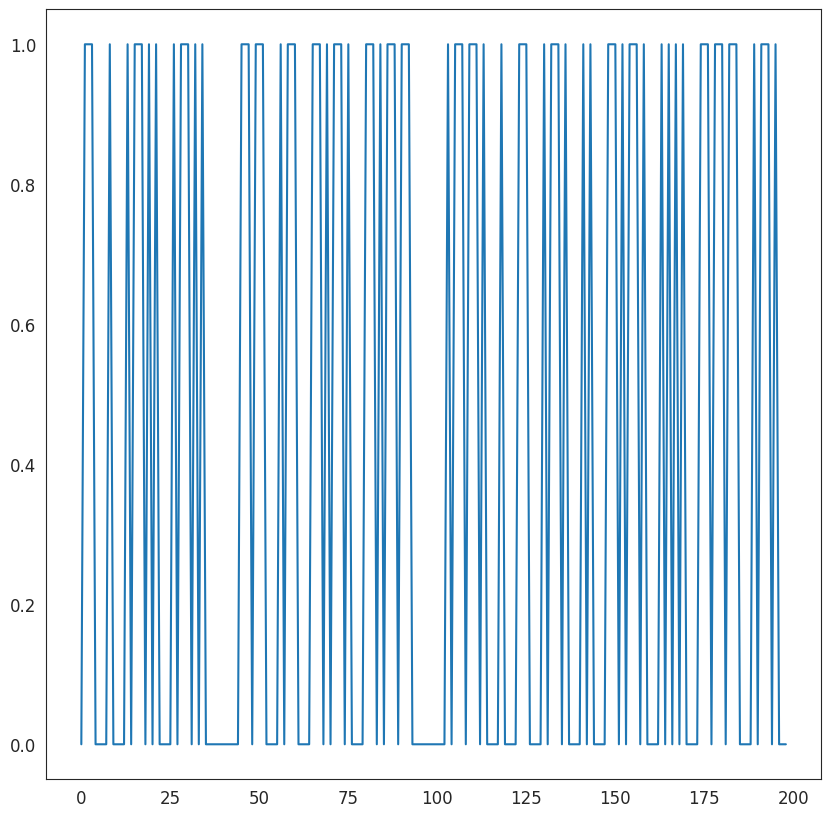

In [43]:
plt.plot(t,dmag)

In [44]:
fwhm = 4
sigma = fwhm*gaussian_fwhm_to_sigma

In [45]:
params = {
          'sigma_x' : sigma,
          'sigma_y' : sigma,
}

In [46]:
psf = generate_psf(201, params, 'Gaussian' )

In [47]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [48]:
tel_params ={
            'aperture'       : 11*2.5,
            'pixel_scale'    : 1.25,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                  f'{data_path}/INSIST/UV/Dichroic.dat,2,100',   # 2 dichroics
                                  f'{data_path}/INSIST/UV/Filter.dat,1,100',
                                ],
             'coeffs'       : 3.8e-2,
             'theta'        : 0
            }

In [49]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         : 68,
              'FWC'        : 58e3,
              'bias'       : 20,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3.4,
              'T'          :  225,
              'DN'         :  0.01/100
              }

# **Example 1**

In [ ]:
x = np.random.uniform(20,280,15)
y = np.random.uniform(20,280,15)
mag = np.random.uniform(8,12,15)
df = pd.DataFrame(zip(x,y,mag), columns = ['x', 'y', 'mag'])

In [ ]:
tabs = []
for i in range(len(dmag)):
  df['x'] = x + np.random.uniform(-10,10,1)[0]
  df['y'] = y + np.random.uniform(-10,10,1)[0]
  df['mag'][0] =  8 + dmag[i]

  sim = pt.Imager(df = df,tel_params = tel_params, exp_time = 10, plot = False,
             n_x = 300, n_y = 300)

  sim(det_params = det_params, photometry = 'Aper')
  tabs.append(sim.phot_table[sim.phot_table['mag_in']==8 + dmag[i]])
  sim.writecomp(f'/content/{i}_sim.fits')
  del sim

Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


Converting xy to ra-dec
Converting xy to ra-dec


/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP
/usr/local/lib/python3.10/dist-packages/pista/analysis.py:181: RuntimeWarning: invalid value encountered in log10
  phot_table['mag_out'] = -2.5*np.log10(phot_table['flux']) + ZP


In [ ]:
tab_t = vstack(tabs)

In [ ]:
!zip  flare_sim.zip flare/*

In [ ]:
tab_t.write('Phot_table.fits')

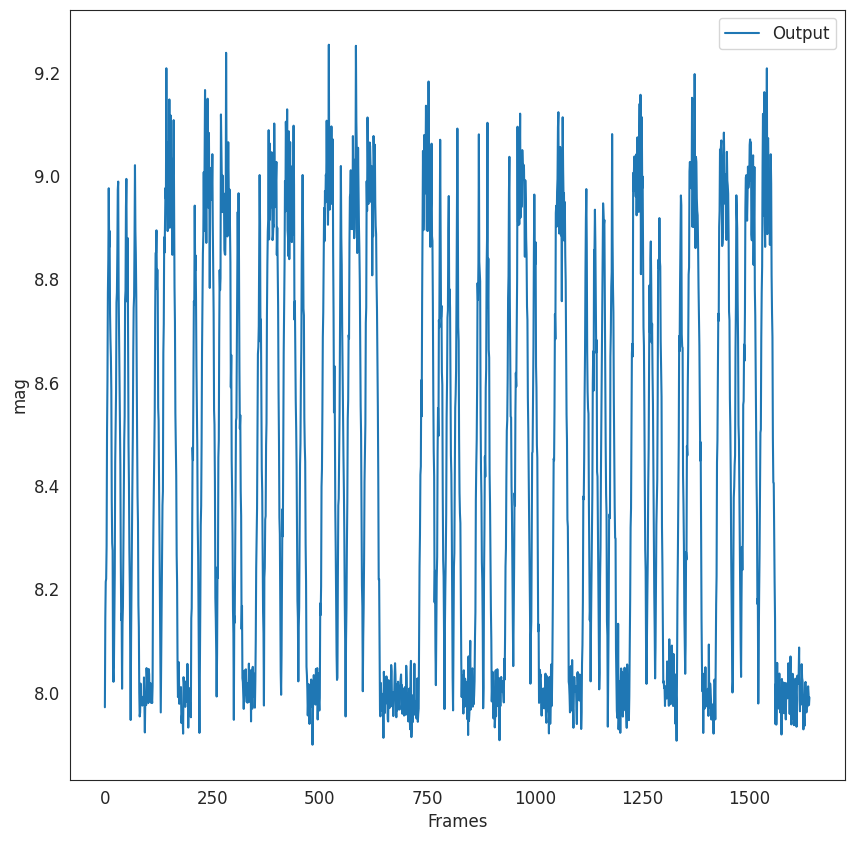

In [40]:
fig, ax = plt.subplots()
ax.plot(tab_t['mag_out'])
#ax.plot(tab_t['mag_in'])
ax.set_xlabel('Frames')
ax.set_ylabel('mag')
#ax.invert_yaxis()
plt.legend(['Output','Input'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp flare/* drive/MyDrive/Flare_sim/

In [ ]:
lc = []
lc_err = []
for sim in sims:
  lc.append(sim.phot_table['mag_out'].value[0])
  lc_err.append(sim.phot_table['mag_err'].value[0])

In [ ]:
y = np.array(lc)
y_err = np.array(lc_err)

plt.errorbar(t[:10],y,yerr= y_err,fmt='-o', color = 'black', markersize=4, capsize=5)
plt.xlabel('Time (Days)')
plt.ylabel('Magnitude')

# **Example 2**

In [ ]:
!mkdir GIF

In [ ]:
tab = Table.read(f'{data_path}/sample.fits')

mult = np.zeros(len(tab))
mult[tab['mag'].argmin()]=1

tab['mags'] = tab['mag'].value.reshape(-1,1) + mult.reshape(-1,1)*dmag.reshape(1,-1)

In [ ]:
sims=[]
for i in range (len(tab['mags'][0])):

  df = tab[['ra','dec']].to_pandas().copy()

  df['mag'] = tab['mags'].value[:,i]

  sim = pt.Imager(df = df,tel_params = tel_params, exp_time = 2400, plot = False,
             n_x = 800, n_y = 800)

  sim(det_params = det_params, photometry = 'Aper')
  sim.show_image()
  plt.savefig(f'GIF/{i:003}', dpi = 100, bbox_inches='tight')

  sims.append(sim)

In [ ]:
import os
from PIL import Image

image_dir = 'GIF'  # Replace with the path to your image directory
output_filename = 'animation.gif'  # Replace with the desired output filename

# Get a list of image filenames in the directory
image_filenames = [filename for filename in os.listdir(image_dir) if filename.endswith('.png')]

# Sort the filenames to ensure proper ordering
image_filenames.sort()

# Open and load each image
image_gif = []
for filename in image_filenames:
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path)
    image_gif.append(image)

# Save the images as an animated GIF

In [ ]:
imageio.mimsave(output_filename, image_gif, 'GIF')

In [ ]:
df1 = sims[0].phot_table

mags = []
for i in range(len(sims)):
  df2 = sims[i].phot_table
  matched = np.array(Xmatch(df1,df2))
  mag = df2['mag_out'].value[matched[:,1].astype(int)]
  mags.append(mag)
mags = np.array(mags)

In [ ]:
index = np.where((np.nanstd(mags, axis = 0)>0.3) & (np.std(mags, axis = 0) != np.nan) )[0]

In [ ]:
index

In [ ]:
for i in index:
  plt.plot(mags[:,i])
  plt.show()